In [1]:
#path = '/Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Deep_learning/Final project/data/dataset/Revco/'

path = r'X:\Processed_data'

#Sequence size for both training model and evaluation
seq_size = 30

In [2]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, IterableDataset
import numpy as np
import torch.nn as nn
import torch
import torch.nn as nn

# Define the window size and number of features
num_features = 330

class AutoEncoder(nn.Module):
    def __init__(self, hidden_units1, hidden_units2, hidden_units3, latent_features):
        super(AutoEncoder, self).__init__()
        
        # Encoder
        self.encoder_gru1 = nn.GRU(input_size=num_features, hidden_size=hidden_units1, batch_first=True)
        self.encoder_gru2 = nn.GRU(input_size=hidden_units1, hidden_size=hidden_units2, batch_first=True)
        self.encoder_gru3 = nn.GRU(input_size=hidden_units2, hidden_size=hidden_units3, batch_first=True)
        self.fc_latent = nn.Linear(hidden_units3, latent_features)
        
        # Decoder
        self.decoder_fc = nn.Linear(latent_features, hidden_units3)
        self.decoder_gru1 = nn.GRU(input_size=hidden_units3, hidden_size=hidden_units3, batch_first=True)
        self.decoder_gru2 = nn.GRU(input_size=hidden_units3, hidden_size=hidden_units2, batch_first=True)
        self.decoder_gru3 = nn.GRU(input_size=hidden_units2, hidden_size=hidden_units1, batch_first=True)
        self.fc_out = nn.Linear(hidden_units1, num_features)
    
    def forward(self, x):
        # Encoder
        x, _ = self.encoder_gru1(x)  # Output: (batch_size, seq_len, hidden_units1)
        x, _ = self.encoder_gru2(x)  # Output: (batch_size, seq_len, hidden_units2)
        x, _ = self.encoder_gru3(x)  # Output: (batch_size, seq_len, hidden_units3)
        
        # Use the last time step for the latent representation
        latent = self.fc_latent(x[:, -1, :])  # Extract the last time step for each sequence
    
        # Decoder
        decoded = self.decoder_fc(latent)  # Map latent representation to hidden_units3
        decoded = decoded.unsqueeze(1).repeat(1, x.size(1), 1)  # Expand to match seq_len
        decoded, _ = self.decoder_gru1(decoded)  # Output: (batch_size, seq_len, hidden_units3)
        decoded, _ = self.decoder_gru2(decoded)  # Output: (batch_size, seq_len, hidden_units2)
        decoded, _ = self.decoder_gru3(decoded)  # Output: (batch_size, seq_len, hidden_units1)
        output = torch.sigmoid(self.fc_out(decoded))  # Map to the original feature space

        
        return {'z': latent, 'x_hat': output}

# Initialize the autoencoder model
hidden_units1 = 256
hidden_units2 = 128
hidden_units3 = 64
latent_features = 32
net = AutoEncoder(hidden_units1, hidden_units2, hidden_units3, latent_features)

# Check if CUDA is available and move the model to GPU
cuda = torch.cuda.is_available()
if cuda:
    net = net.cuda()

print(net)

AutoEncoder(
  (encoder_gru1): GRU(330, 256, batch_first=True)
  (encoder_gru2): GRU(256, 128, batch_first=True)
  (encoder_gru3): GRU(128, 64, batch_first=True)
  (fc_latent): Linear(in_features=64, out_features=32, bias=True)
  (decoder_fc): Linear(in_features=32, out_features=64, bias=True)
  (decoder_gru1): GRU(64, 64, batch_first=True)
  (decoder_gru2): GRU(64, 128, batch_first=True)
  (decoder_gru3): GRU(128, 256, batch_first=True)
  (fc_out): Linear(in_features=256, out_features=330, bias=True)
)


## Training loop

In [3]:
import os
import torch
from torch.utils.data import DataLoader, Dataset
import pyarrow.parquet as pq
import numpy as np

# Define your window size and other parameters
batch_size = 512
num_epochs = 3

model = AutoEncoder(hidden_units1, hidden_units2, hidden_units3, latent_features)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)  # Move model to the device

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
loss_function = torch.nn.MSELoss()

# Define your dataset class
class FragmentDataset(Dataset):
    def __init__(self, data, window_size):
        self.window_size = window_size
        self.data = data  # Data is a GPU tensor of shape (num_samples, num_features)
        self.length = len(data) - window_size + 1

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        x = self.data[index:index + self.window_size]  # Shape: (window_size, num_features)
        return x, x  # Input and target for autoencoder

# Directory where the Parquet files are stored
fragments_dir = r'X:\Processed_data'

# Get list of fragment files
fragment_files = [
    os.path.join(fragments_dir, f)
    for f in os.listdir(fragments_dir)
    if f.endswith('.parquet')
]

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    epoch_loss = []

    for file_path in fragment_files:
        print(f"Processing fragment: {file_path}")

        # Load data and move to GPU
        parquet_file = pq.ParquetFile(file_path)
        data = parquet_file.read().to_pandas().to_numpy(dtype='float32')
        data_tensor = torch.tensor(data, dtype=torch.float32).to(device)

        # Create Dataset and DataLoader
        fragment_dataset = FragmentDataset(data_tensor, seq_size)
        train_loader = DataLoader(
            fragment_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=0  # Must be 0 when data is on GPU
        )

        model.train()
        for x, _ in train_loader:
            outputs = model(x)
            x_hat = outputs['x_hat']
            loss = loss_function(x_hat, x)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss.append(loss.item())

        # After processing the fragment, delete variables and free GPU memory
        del data_tensor
        del fragment_dataset
        del train_loader
        torch.cuda.empty_cache()  # Releases GPU memory

    avg_loss = np.mean(epoch_loss)
    print(f"Epoch {epoch + 1}/{num_epochs}, Average Loss: {avg_loss:.6f}")

    # Save the model state dict
    torch.save(model, f"autoencoder_epoch_{epoch + 1}.pth")

print("Training complete!")

Using device: cuda
Epoch 1/3
Processing fragment: X:\Processed_data\processed_806016.parquet
Processing fragment: X:\Processed_data\processed_806019.parquet
Processing fragment: X:\Processed_data\processed_806020.parquet
Processing fragment: X:\Processed_data\processed_806021.parquet
Processing fragment: X:\Processed_data\processed_806024.parquet
Processing fragment: X:\Processed_data\processed_806027.parquet
Processing fragment: X:\Processed_data\processed_806028.parquet
Processing fragment: X:\Processed_data\processed_806029.parquet
Processing fragment: X:\Processed_data\processed_806030.parquet
Processing fragment: X:\Processed_data\processed_806267.parquet
Processing fragment: X:\Processed_data\processed_806268.parquet
Processing fragment: X:\Processed_data\processed_806269.parquet
Processing fragment: X:\Processed_data\processed_806270.parquet
Processing fragment: X:\Processed_data\processed_806271.parquet
Processing fragment: X:\Processed_data\processed_806272.parquet
Processing 

KeyboardInterrupt: 

## Load the model

In [3]:
import torch
from torch.utils.data import DataLoader, Dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the entire model
net_loaded = torch.load('autoencoder_epoch_3_GRU.pth', map_location=device)
net_loaded.to(device)
net_loaded.eval()

C:\Users\claes\AppData\Local\Temp\ipykernel_4568\3293759487.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net_loaded = torch.load('autoencoder_epoch_3_GRU.pth', map_lo

AutoEncoder(
  (encoder_gru1): GRU(330, 256, batch_first=True)
  (encoder_gru2): GRU(256, 128, batch_first=True)
  (encoder_gru3): GRU(128, 64, batch_first=True)
  (fc_latent): Linear(in_features=64, out_features=32, bias=True)
  (decoder_fc): Linear(in_features=32, out_features=64, bias=True)
  (decoder_gru1): GRU(64, 64, batch_first=True)
  (decoder_gru2): GRU(64, 128, batch_first=True)
  (decoder_gru3): GRU(128, 256, batch_first=True)
  (fc_out): Linear(in_features=256, out_features=330, bias=True)
)

### Functions to prepare data for performance eval

In [4]:
import os
import torch
import pyarrow.parquet as pq
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import gc  # Garbage collection

# Define the detect_anomalies function with batch processing
def detect_anomalies_in_batches(data, model, device, batch_size=512, threshold=0.08):
    model.eval()
    dataset = torch.utils.data.TensorDataset(torch.tensor(data, dtype=torch.float32))  # Shape: (num_windows, seq_len, num_features)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    reconstruction_errors = []
    
    with torch.no_grad():
        for batch in dataloader:
            data_tensor = batch[0].to(device)  # Shape: (batch_size, seq_len, num_features)
            outputs = model(data_tensor)
            x_hat = outputs['x_hat']
            # Compute reconstruction errors for each sequence
            batch_errors = torch.mean((data_tensor - x_hat) ** 2, dim=(1, 2)).cpu().numpy()
            reconstruction_errors.extend(batch_errors)
    
    reconstruction_errors = np.array(reconstruction_errors)
    anomalies = reconstruction_errors > threshold
    return anomalies, reconstruction_errors

def reshape_to_sliding_windows(data, window_size):
    num_samples, num_features = data.shape
    windows = []
    for i in range(num_samples - window_size + 1):
        windows.append(data[i:i + window_size])  # Collect sliding windows
    return np.array(windows, dtype=np.float32)

# Define sliding window processing function
def process_chunk(data_chunk, model, device, window_size, batch_size, threshold):
    # Convert data into sliding windows
    data_chunk = reshape_to_sliding_windows(data_chunk, window_size)
    # Detect anomalies in the chunk
    anomalies, reconstruction_errors = detect_anomalies_in_batches(data_chunk, model, device, batch_size, threshold)
    return anomalies, reconstruction_errors


## Test on training data

Using device: cuda
Processing file: X:\Processed_data\processed_806019.parquet
Processing row group 1/4
Processing row group 2/4
Processing row group 3/4
Processing row group 4/4


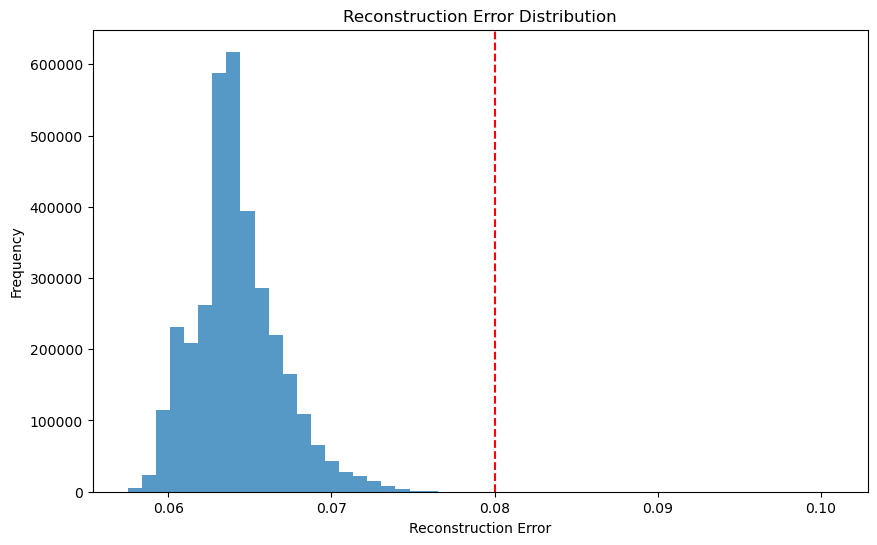

Detected 145 anomalies out of 3,412,366 samples.


In [15]:
import os
import torch
import pyarrow.parquet as pq
import numpy as np
import matplotlib.pyplot as plt
import gc  # Garbage collection

# Directory where the Parquet files are stored
fragments_dir = r'X:\Processed_data'

# List of Parquet files
fragment_files = [
    os.path.join(fragments_dir, f)
    for f in os.listdir(fragments_dir)
    if f.endswith('.parquet')
]

file_number = 1

# Ensure device is defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load trained model
model = AutoEncoder(hidden_units1, hidden_units2, hidden_units3, latent_features)
model.to(device)

# Parameters
batch_size = 512
threshold = 0.08
chunk_size = 10_000  # Reduce chunk size for better memory management

# Initialize lists to collect results
all_anomalies = []
all_reconstruction_errors = []

# Process the file in chunks
print(f"Processing file: {fragment_files[file_number]}")
parquet_file = pq.ParquetFile(fragment_files[file_number])

for row_group_idx in range(parquet_file.num_row_groups):
    print(f"Processing row group {row_group_idx + 1}/{parquet_file.num_row_groups}")
    
    # Read a row group into memory
    data_chunk = parquet_file.read_row_group(row_group_idx).to_pandas().to_numpy(dtype='float32')
    num_rows = data_chunk.shape[0]
    
    # Split the row group into smaller chunks
    for start_idx in range(0, num_rows, chunk_size):
        end_idx = min(start_idx + chunk_size, num_rows)
        chunk_df = data_chunk[start_idx:end_idx]
        
        # Process the current chunk
        anomalies, reconstruction_errors = process_chunk(chunk_df, model, device, seq_size, batch_size, threshold)
        
        # Collect results
        all_anomalies.extend(anomalies)
        all_reconstruction_errors.extend(reconstruction_errors)
        
        # Clear memory
        del chunk_df
        gc.collect()  # Trigger garbage collection
    
    # Clear row group data after processing
    del data_chunk
    gc.collect()

# Convert results to NumPy arrays
all_reconstruction_errors = np.array(all_reconstruction_errors)
all_anomalies = np.array(all_anomalies)

# Plot reconstruction error distribution
plt.figure(figsize=(10, 6))
plt.hist(all_reconstruction_errors, bins=50, alpha=0.75)
plt.axvline(x=threshold, color='r', linestyle='--')
plt.title('Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.show()

# Print anomaly statistics
anomaly_indices = np.where(all_anomalies)[0]
print(f"Detected {len(anomaly_indices):,} anomalies out of {len(all_reconstruction_errors):,} samples.")

## Evaluate on testdata

In [30]:
freezer_number = "806033"

### Step 1, clean and scale data file

In [7]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

path = '/Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Deep_learning/Final project/data/dataset/Revco/'

input_file = freezer_number + "_temp.parquet"  # Replace with the correct file name if needed

# Specify the columns to scale
columns_to_scale = [
    'RTD', '1st Suc.', 'Cond. Air In', 'Evap. In', 'Evap. Out', 
    '2nd Suc.', 'Chil. water In', '2nd Sump', 'H.E.', 
    'SetPoint', 'Mains Voltage'
]

# Load the combined data (assuming it's already saved as 'combined_data.parquet')
data = pd.read_parquet(path + input_file)

# Filter out rows where the freezer is off
data = data[(data['Mains Voltage'] >= 200)]

# Check if all columns are present in the dataset
missing_columns = [col for col in columns_to_scale if col not in data.columns]
if missing_columns:
    raise ValueError(f"The following columns are missing in the data: {missing_columns}")

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Scale the specified columns
data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])

# Save the scaled dataset back to Parquet
scaled_output_file = "scaled_" + freezer_number + "_data.parquet"
data.to_parquet(path + scaled_output_file)

print(f"Scaled data saved as {scaled_output_file}")

Scaled data saved as scaled_806026_data.parquet


### Step 2, make data windowed

In [3]:
import pandas as pd
import dask.dataframe as dd
import dask.array as da
from dask.delayed import delayed
import os
import tempfile
import shutil
from joblib import Parallel, delayed as joblib_delayed
from tqdm import tqdm
import gc  # Import garbage collection module

##### Brug ML env #####

# Constants
input_path = '/Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Deep_learning/Final project/data/dataset/Revco/'
output_path = '/Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Deep_learning/Final project/data/dataset/Revco/'
num_cores = -1  # Use all available cores

# List of freezer numbers to process
freezer_numbers = [ freezer_number ]

# Function to process a single freezer
def process_freezer(freezer_number):
    temp_dir = tempfile.mkdtemp()
    temp_output_file = os.path.join(temp_dir, f"processed_{freezer_number}_temp")
    final_output_file = os.path.join(output_path, f"test_ready_{freezer_number}.parquet")

    try:
        # Load data using Dask
        df = dd.read_parquet(input_path + f'scaled_{freezer_number}_data.parquet')
        
        # Step 1: Drop unnecessary columns
        drop_columns_set_1 = ['State', 'Type', 'Event']
        drop_columns_set_2 = drop_columns_set_1 + ['main_fault']
        if 'main_fault' in df.columns:
            df = df.drop(columns=[col for col in drop_columns_set_2 if col in df.columns])
        else:
            df = df.drop(columns=[col for col in drop_columns_set_1 if col in df.columns])

        # Convert to pandas for time-based operations
        df = df.compute()

        # Step 2: Ensure datetime format
        df['Datetime'] = pd.to_datetime(df['Datetime'])

        # Step 3: Identify continuous sequences
        df['time_diff'] = df['Datetime'].diff().dt.total_seconds()
        df['is_continuous'] = (df['time_diff'].between(1, 120)) | (df.index == 0)
        df['sequence_group'] = (~df['is_continuous']).cumsum()

        # Step 5: Filter valid sequences
        valid_sequences = df.groupby('sequence_group').filter(lambda x: len(x) >= seq_size)

        # Get the original feature names
        feature_names = [col for col in valid_sequences.columns 
                         if col not in ['Datetime', 'time_diff', 'is_continuous', 'sequence_group']]

        def process_group(group):
            group_windows = []
            datetime_output = []  # Store one Datetime per flattened window

            for start_idx in range(0, len(group) - seq_size + 1):
                window = group.iloc[start_idx:start_idx + seq_size]
                
                # Save the first 'Datetime' of the window as representative for the flattened window
                datetime_output.append(window['Datetime'].iloc[0])
                
                # Flatten the other columns (excluding 'Datetime')
                flattened_window = window.drop(
                    ['Datetime', 'time_diff', 'is_continuous', 'sequence_group'], axis=1
                ).values.flatten()
                group_windows.append(flattened_window)
            
            return group_windows, datetime_output

        # Process groups in chunks to manage memory
        chunk_size = 10
        groups = [group for _, group in valid_sequences.groupby('sequence_group')]
        num_chunks = (len(groups) + chunk_size - 1) // chunk_size

        # Create column names for the flattened data
        feature_columns = [f'feature_{i}_{t}' for i in range(seq_size) for t in feature_names]

        # Process chunks and write to temporary file
        first_chunk = True

        for chunk_idx in range(num_chunks):
            start_idx = chunk_idx * chunk_size
            end_idx = min((chunk_idx + 1) * chunk_size, len(groups))
            chunk_groups = groups[start_idx:end_idx]
            
            # Process chunk using parallel processing
            chunk_results = Parallel(n_jobs=num_cores)(
                joblib_delayed(process_group)(group) for group in tqdm(
                    chunk_groups, 
                    desc=f"Processing Freezer {freezer_number} Chunk {chunk_idx + 1}/{num_chunks}",
                    unit="group"
                )
            )
            
            # Split the results into data windows and datetime outputs
            chunk_windows, datetime_outputs = zip(*chunk_results)

            # Flatten the chunk results
            chunk_windows = [window for group_windows in chunk_windows for window in group_windows]
            datetime_outputs = [dt for group_datetimes in datetime_outputs for dt in group_datetimes]

            # Convert chunk to DataFrame
            chunk_df = pd.DataFrame(chunk_windows, columns=feature_columns)
            chunk_df['Datetime'] = datetime_outputs  # Add Datetime column to the output DataFrame

            # Write processed data to temporary parquet file
            if first_chunk:
                chunk_df.to_parquet(temp_output_file, index=False)
                first_chunk = False
            else:
                chunk_df.to_parquet(temp_output_file, index=False, append=True)
            
            # Clear memory
            del chunk_windows, datetime_outputs, chunk_df
            gc.collect()

        # Move the temporary file to the final location with a new name
        shutil.move(temp_output_file, final_output_file)
        
        print(f"Successfully saved processed file to: {final_output_file}")

    finally:
        # Clean up temporary directory
        try:
            shutil.rmtree(temp_dir)
        except:
            pass
        
        # Explicitly delete variables and run garbage collection
        del df, valid_sequences, groups, feature_names, drop_columns_set_1, drop_columns_set_2
        gc.collect()

# Process all freezers
for freezer_number in freezer_numbers:
    print(f"Processing freezer: {freezer_number}")
    process_freezer(freezer_number)

c:\Users\claes\anaconda3\envs\ML\Lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
c:\Users\claes\anaconda3\envs\ML\Lib\site-packages\dask\dataframe\io\parquet\core.py:1247: FutureWarning: Could not find pyarrow; falling back to fastparquet, which is deprecated and will be removed in a future release.
  warnings.warn(


Processing freezer: 806033


Processing Freezer 806033 Chunk 7/7: 100%|██████████| 6/6 [00:00<?, ?group/s]


Successfully saved processed file to: /Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Deep_learning/Final project/data/dataset/Revco/test_ready_806033.parquet


### Make results data from test data

In [31]:
import os
import torch
import pyarrow.parquet as pq
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc  # Garbage collection
import tempfile
import warnings
from pandas.errors import PerformanceWarning

# Suppress PerformanceWarnings from pandas
warnings.simplefilter(action='ignore', category=PerformanceWarning)

path = '/Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Deep_learning/Final project/data/dataset/Revco/'

# Ensure device is defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load trained model
model = AutoEncoder(hidden_units1, hidden_units2, hidden_units3, latent_features)
model.to(device)

# Parameters
batch_size = 512
threshold = 0.0842 # Based on mu + 3 * sigma for entire testset
chunk_size = 10_000  # Reduce chunk size for better memory management

# Temporary directory for storing intermediate results
temp_dir = tempfile.TemporaryDirectory()

print("Processing file:" + "test_ready_" + freezer_number + ".parquet")
parquet_file = pq.ParquetFile(path + "test_ready_" + freezer_number + ".parquet")

chunk_files = []  # To keep track of temporary files

for row_group_idx in range(parquet_file.num_row_groups):
    print(f"Processing row group {row_group_idx + 1}/{parquet_file.num_row_groups}")
    
    # Read a row group into memory
    data_chunk = parquet_file.read_row_group(row_group_idx).to_pandas()
    
    # Keep 'Datetime' column separately
    if 'Datetime' in data_chunk.columns:
        datetimes = data_chunk['Datetime']
        data_chunk = data_chunk.drop(columns=['Datetime'])
    else:
        datetimes = None
    
    # Convert to NumPy array
    data_chunk_np = data_chunk.to_numpy(dtype='float32')
    num_rows = data_chunk_np.shape[0]
    
    # Split the row group into smaller chunks
    for start_idx in range(0, num_rows, chunk_size):
        end_idx = min(start_idx + chunk_size, num_rows)
        chunk_df = data_chunk.iloc[start_idx:end_idx]  # Retain original columns
        chunk_datetimes = datetimes[start_idx:end_idx] if datetimes is not None else None
        chunk_np = data_chunk_np[start_idx:end_idx]
        
        # Process the current chunk
        anomalies, reconstruction_errors = process_chunk(chunk_np, model, device, seq_size, batch_size, threshold)
        
        # Create a DataFrame for the current chunk
        chunk_results = pd.DataFrame({
            'Datetime': chunk_datetimes.iloc[seq_size - 1:].values if chunk_datetimes is not None else None,
            'reconstruction_error': reconstruction_errors,
            'anomaly': anomalies
        })
        for col in chunk_df.columns:
            chunk_results[col] = chunk_df.iloc[seq_size - 1:].values[:, chunk_df.columns.get_loc(col)]
        
        # Write the chunk results to a temporary file
        temp_file_path = os.path.join(temp_dir.name, f"chunk_{row_group_idx}_{start_idx}.parquet")
        chunk_results.to_parquet(temp_file_path, index=False)
        chunk_files.append(temp_file_path)
        
        # Clear memory
        del chunk_df, chunk_np, chunk_results
        gc.collect()  # Trigger garbage collection
    
    # Clear row group data after processing
    del data_chunk, data_chunk_np
    gc.collect()

# Combine all temporary files into a single DataFrame
results_df = pd.concat([pd.read_parquet(f) for f in chunk_files], ignore_index=True)

# Save the scaled dataset back to Parquet
results_output_file = "test_results_" + freezer_number + ".parquet"
results_df.to_parquet(path + results_output_file)

# Cleanup temporary files
temp_dir.cleanup()

Using device: cuda
Processing file:test_ready_806033.parquet
Processing row group 1/7
Processing row group 2/7
Processing row group 3/7
Processing row group 4/7
Processing row group 5/7
Processing row group 6/7
Processing row group 7/7


### Plot reconstruction error

Loading test results from: /Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Deep_learning/Final project/data/dataset/Revco/test_results_806033.parquet
0.12434899481013417


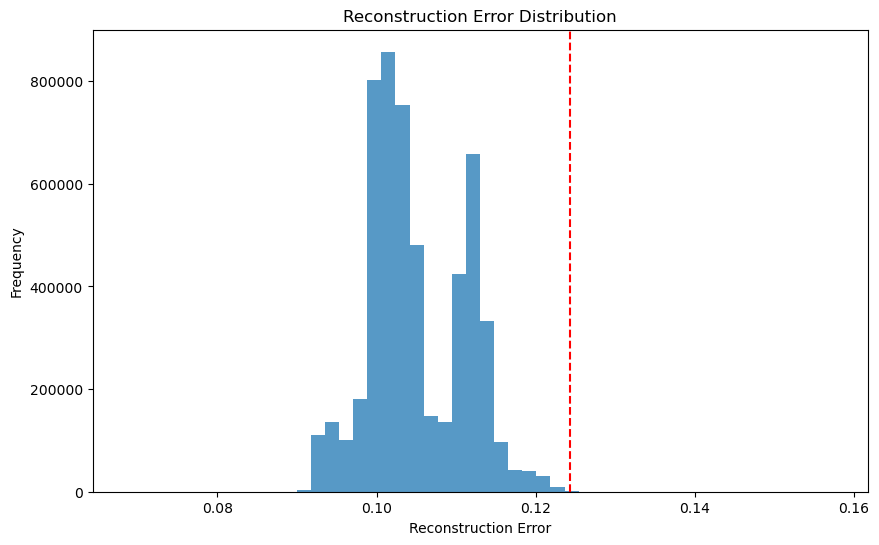

Detected 5,346,492 anomalies out of 5,347,820 samples.


In [32]:
import pyarrow.parquet as pq
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Path where the test results are saved
path = '/Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Deep_learning/Final project/data/dataset/Revco/'

# Load the test results parquet file
results_file = path + f"test_results_{freezer_number}.parquet"
print(f"Loading test results from: {results_file}")
results_df = pd.read_parquet(results_file)

mu = results_df['reconstruction_error'].mean()
sigma = results_df['reconstruction_error'].std()

# Parameters
threshold = mu + 3 * sigma  # Reconstruction error threshold for anomalies
print(threshold)

# Ensure the reconstruction_error column exists
if 'reconstruction_error' not in results_df.columns:
    raise ValueError("The column 'reconstruction_error' is not found in the test results file.")

# Extract reconstruction errors
reconstruction_errors = results_df['reconstruction_error'].values

# Plot the reconstruction error distribution
plt.figure(figsize=(10, 6))
plt.hist(reconstruction_errors, bins=50, alpha=0.75)
plt.axvline(x=threshold, color='r', linestyle='--')
plt.title('Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.show()

# Calculate anomaly statistics
anomalies = results_df['anomaly'].values if 'anomaly' in results_df.columns else reconstruction_errors > threshold
anomaly_count = np.sum(anomalies)
total_count = len(reconstruction_errors)
print(f"Detected {anomaly_count:,} anomalies out of {total_count:,} samples.")

### Plot control chart with error

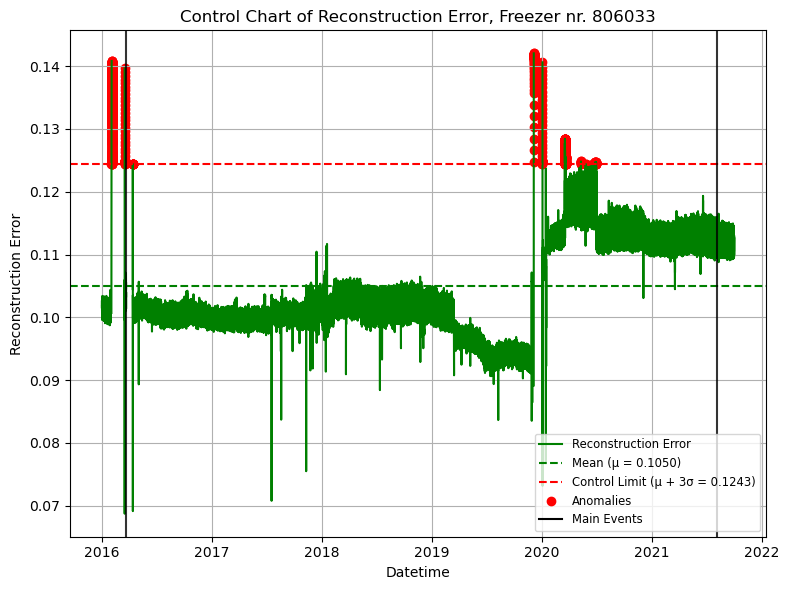

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D  # For creating custom legend entries

# Define the date range for filtering
start_date = '2016-01-01'
end_date = '2021-10-01'

# Ensure 'Datetime' is in datetime format
results_df['Datetime'] = pd.to_datetime(results_df['Datetime'])

### Test freezers

if freezer_number == "806017":
    # Event dates to mark on the plot
    event_dates = ['2015-02-13 13:54:03', '2015-03-19', '2022-08-22']
    event_types = ['compressor_stage_2 malfunction'] #, 'refrigerant leakage at stage 1', 'high condensation water'

if freezer_number == "806018":
    # Event dates to mark on the plot
    event_dates = ['2022-08-22','2022-10-04', '2022-12-05', '2023-02-06']
    event_types = ['electrical malfunction', 'refrigerant leakage at stage 1', 'unstable operation (no fix)', 'unstable operation (no fix)']

if freezer_number == "806026":
    # Event dates to mark on the plot
    event_dates = ['2016-06-09', '2016-08-11','2022-07-19'] 
    event_types = ['compressor_stage_2', 'wrong setpoint','compressor_stage_2 piston sticking']

if freezer_number == "806031":
    # Event dates to mark on the plot
    event_dates = ['2017-02-23', '2017-09-20'] #, '2023-02-03'
    event_types = ['compressor_stage_2 malfunction', 'logic_wiring'] #, 'filter_drier'

if freezer_number == "806033":
    # Event dates to mark on the plot
    event_dates = ['2016-03-21', '2021-08-06']
    event_types = ['compressor_stage_2 malfunction', 'electrical malfunction']
    
event_dates = pd.to_datetime(event_dates)  # Convert to datetime

# Sort the DataFrame by 'Datetime' if not already sorted
results_df = results_df.sort_values('Datetime')

# Calculate time differences between consecutive rows
time_diffs = results_df['Datetime'].diff()

# Define a threshold for detecting gaps (e.g., 1 day)
gap_threshold = pd.Timedelta(days=1)

# Introduce NaN for rows where the time difference exceeds the threshold
results_df.loc[time_diffs > gap_threshold, 'reconstruction_error'] = np.nan

# Calculate mean and standard deviation
mu = results_df['reconstruction_error'].mean()
sigma = results_df['reconstruction_error'].std()

# Filter the DataFrame to include only rows within the specified range
results_df = results_df[(results_df['Datetime'] >= start_date) & (results_df['Datetime'] <= end_date)]

# Define control limits
upper_control_limit = mu + 3 * sigma

# Initialize the plot
plt.figure(figsize=(8, 6))
plt.plot(results_df['Datetime'], results_df['reconstruction_error'], label='Reconstruction Error', color='green')

# Plot the mean line
plt.axhline(mu, color='green', linestyle='--', label=f'Mean (μ = {mu:.4f})')

# Plot control limits
plt.axhline(upper_control_limit, color='red', linestyle='--', label=f'Control Limit (μ + 3σ = {upper_control_limit:.4f})')

# Add vertical black lines for each event date without individual labels
for event_date in event_dates:
    plt.axvline(event_date, color='black', linestyle='-', alpha=0.8, linewidth=1.5)

# Highlight anomalies
anomalies = results_df[(results_df['reconstruction_error'] > upper_control_limit)]

plt.scatter(anomalies['Datetime'], anomalies['reconstruction_error'], color='red', label='Anomalies')

# Create a custom legend entry for event lines
event_legend = Line2D([0], [0], color='black', linestyle='-', label='Main Events', )

# Customize the plot
plt.title('Control Chart of Reconstruction Error,'+ " Freezer nr. " + freezer_number)
plt.xlabel('Datetime')
plt.ylabel('Reconstruction Error')
plt.grid(True)

# Combine all legend handles
handles, labels = plt.gca().get_legend_handles_labels()
handles.append(event_legend)
labels.append('Main Events')

# Create the legend
plt.legend(handles=handles, labels=labels, loc='lower right', fontsize='small')

plt.tight_layout()

# Show the plot
plt.show()

In [14]:
import pandas as pd

start_date = '2022-10-03'
end_date = '2022-10-05'

# Read the Parquet file into a DataFrame
results_df = pd.read_parquet(path + '806018_temp.parquet')

# Filter the DataFrame to include only rows within the specified range
results_df = results_df[(results_df['Datetime'] >= start_date) & (results_df['Datetime'] <= end_date)]

results_df = results_df[results_df['Event'].notnull()]

# Display the first few rows
results_df.head(50)

,Datetime,RTD,1st Suc.,Cond. Air In,Evap. In,Evap. Out,2nd Suc.,Chil. water In,2nd Sump,H.E.,SetPoint,Mains Voltage,State,Type,Event,main_fault
index,,,,,,,,,,,,,,,,
4961909,2022-10-03 01:11:33,-78.9,-3.3,23.6,-79.3,-84.3,-57.8,20.6,27.4,-16.5,-80,223.6,3,b'[17]',"b'[""Warm Interstage""]'",None
4962130,2022-10-03 04:52:33,-78.8,-6.4,23.6,-79.0,-84.3,-57.0,20.6,26.6,-18.0,-80,222.7,3,b'[17]',"b'[""Warm Interstage""]'",None
4962477,2022-10-03 10:39:33,-78.9,-2.6,23.5,-79.4,-84.4,-57.8,20.9,27.1,-16.3,-80,220.4,3,b'[17]',"b'[""Warm Interstage""]'",None
4962764,2022-10-03 15:26:34,-78.8,-4.4,23.7,-79.1,-84.3,-56.6,20.2,26.9,-16.9,-80,221.0,3,b'[17]',"b'[""Warm Interstage""]'",None
4963049,2022-10-03 20:11:33,-78.9,-4.9,23.9,-79.0,-84.3,-57.0,20.0,26.7,-15.9,-80,222.3,3,b'[17]',"b'[""Warm Interstage""]'",None
4963307,2022-10-04 00:29:33,-78.8,-3.1,23.4,-79.5,-84.4,-57.4,22.5,27.6,-18.8,-80,223.0,3,b'[17]',"b'[""Warm Interstage""]'",None
4963751,2022-10-04 07:53:33,-78.8,-6.1,23.2,-79.0,-84.4,-57.1,20.3,26.2,-17.0,-80,221.3,3,b'[17]',"b'[""Warm Interstage""]'",None
4963976,2022-10-04 11:38:33,-78.8,-5.7,22.9,-79.3,-84.5,-56.6,21.3,26.0,-19.6,-80,220.7,3,b'[17]',"b'[""Warm Interstage""]'",None
4964102,2022-10-04 13:44:33,-78.9,-3.5,23.1,-79.2,-84.5,-56.8,20.9,27.2,-16.9,-80,220.5,3,b'[17]',"b'[""Warm Interstage""]'",None


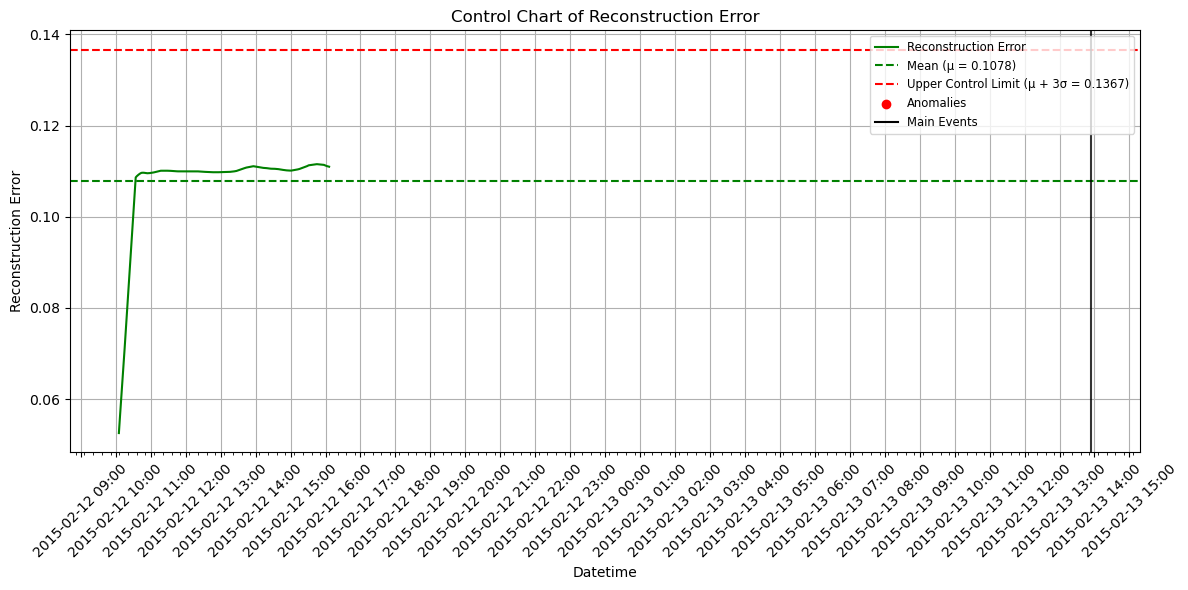

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D  # For creating custom legend entries
from matplotlib.dates import DateFormatter, HourLocator, DayLocator
import matplotlib.dates as mdates

# Define a function to plot reconstruction error
def plot_reconstruction_error(results_df, freezer_number, start_date, end_date, show_hours=False):
    # Ensure 'Datetime' is in datetime format
    results_df['Datetime'] = pd.to_datetime(results_df['Datetime'], errors='coerce')
    
    ### Define Event Dates and Types based on freezer_number
    event_dates_dict = {
        "806017": {
            "dates": ['2015-02-13 13:54:03'],
            "types": ['compressor_stage_2 malfunction']
        },
        "806018": {
            "dates": ['2022-08-22', '2022-10-04', '2022-12-05', '2023-02-06'],
            "types": ['electrical malfunction', 'refrigerant leakage at stage 1', 
                      'unstable operation (no fix)', 'unstable operation (no fix)']
        },
        "806026": {
            "dates": ['2016-06-09', '2016-08-11', '2022-07-19'],
            "types": ['compressor_stage_2', 'wrong setpoint', 'compressor_stage_2 piston sticking']
        },
        "806031": {
            "dates": ['2017-02-23', '2017-09-20', '2023-02-03'],
            "types": ['compressor_stage_2 malfunction', 'logic_wiring', 'filter_drier']
        },
        "806033": {
            "dates": ['2016-03-21', '2021-08-06'],
            "types": ['compressor_stage_2 malfunction', 'electrical malfunction']
        }
    }
    
    # Retrieve event dates and types for the given freezer_number
    if freezer_number in event_dates_dict:
        event_dates = event_dates_dict[freezer_number]['dates']
        event_types = event_dates_dict[freezer_number]['types']
    else:
        event_dates = []
        event_types = []
    
    # Convert event_dates to datetime, setting time to 00:00:00 if not provided
    event_dates = pd.to_datetime(event_dates, errors='coerce')
    event_dates = [d if d.time() != pd.Timestamp.min.time() else d.replace(hour=0, minute=0, second=0) for d in event_dates]
    
    # Sort the DataFrame by 'Datetime' if not already sorted
    results_df = results_df.sort_values('Datetime')
    
    # Calculate time differences between consecutive rows
    time_diffs = results_df['Datetime'].diff()
    
    # Define a threshold for detecting gaps (e.g., 1 day)
    gap_threshold = pd.Timedelta(days=1)
    
    # Introduce NaN for rows where the time difference exceeds the threshold
    results_df.loc[time_diffs > gap_threshold, 'reconstruction_error'] = np.nan
    
    # Filter the DataFrame to include only rows within the specified range
    mask = (results_df['Datetime'] >= start_date) & (results_df['Datetime'] <= end_date)
    results_df = results_df.loc[mask]
    
    # Calculate mean and standard deviation
    mu = results_df['reconstruction_error'].mean()
    sigma = results_df['reconstruction_error'].std()
    
    # Define control limits
    upper_control_limit = mu + 3 * sigma
    
    # Initialize the plot
    plt.figure(figsize=(12, 6))
    plt.plot(results_df['Datetime'], results_df['reconstruction_error'], label='Reconstruction Error', color='green')
    
    # Plot the mean line
    plt.axhline(mu, color='green', linestyle='--', label=f'Mean (μ = {mu:.4f})')
    
    # Plot control limits
    plt.axhline(upper_control_limit, color='red', linestyle='--', label=f'Upper Control Limit (μ + 3σ = {upper_control_limit:.4f})')
    
    # Add vertical black lines for each event date without individual labels
    for event_date in event_dates:
        plt.axvline(event_date, color='black', linestyle='-', alpha=0.8, linewidth=1.5)
    
    # Highlight anomalies
    anomalies = results_df[(results_df['reconstruction_error'] > upper_control_limit)]
    plt.scatter(anomalies['Datetime'], anomalies['reconstruction_error'], color='red', label='Anomalies')
    
    # Create a custom legend entry for event lines
    event_legend = Line2D([0], [0], color='black', linestyle='-', label='Main Events')
    
    # Customize the x-axis based on the show_hours flag
    ax = plt.gca()
    if show_hours:
        # Set major ticks to every hour
        ax.xaxis.set_major_locator(HourLocator())
        # Define the format for hours
        ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d %H:%M'))
        # Optionally, set minor ticks (e.g., every 15 minutes)
        ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval=15))
    else:
        # Set major ticks to every day
        ax.xaxis.set_major_locator(DayLocator())
        # Define the format for days
        ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
        # Optionally, set minor ticks (e.g., every 6 hours)
        ax.xaxis.set_minor_locator(HourLocator(interval=6))
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    
    # Combine all legend handles
    handles, labels = ax.get_legend_handles_labels()
    handles.append(event_legend)
    labels.append('Main Events')
    
    # Create the legend
    plt.legend(handles=handles, labels=labels, loc='upper right', fontsize='small')
    
    # Customize the plot
    plt.title('Control Chart of Reconstruction Error')
    plt.xlabel('Datetime')
    plt.ylabel('Reconstruction Error')
    plt.grid(True)
    
    plt.tight_layout()
    
    # Show the plot
    plt.show()

# Example usage:
# Define your DataFrame `results_df` and other variables appropriately before calling the function.

# Toggle this flag to switch between hours and days
show_hours = True  # Set to False to display days

# Call the plotting function
plot_reconstruction_error(
    results_df=results_df,
    freezer_number="806017",  # Replace with your freezer number
    start_date='2015-02-12',
    end_date='2015-02-14',
    show_hours=show_hours
)


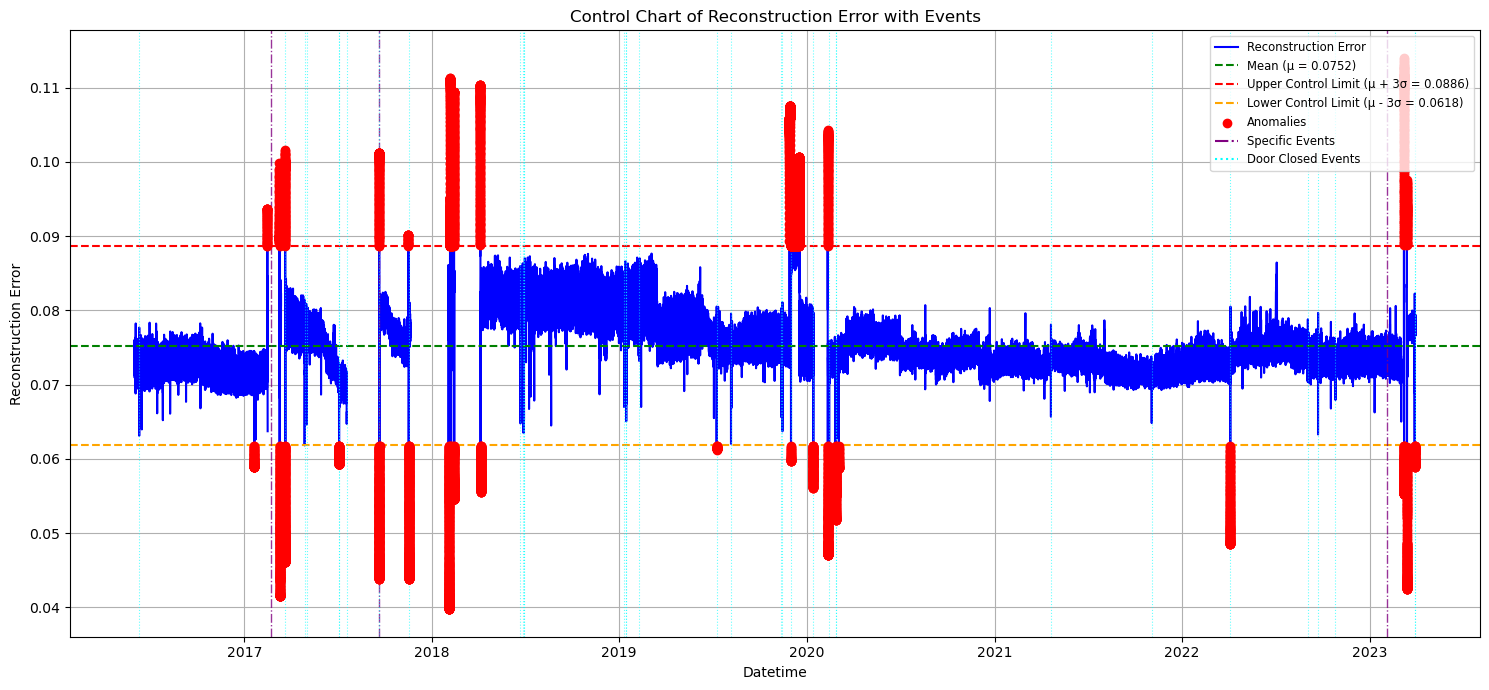

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D  # For creating custom legend entries

path = '/Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Deep_learning/Final project/data/dataset/Revco/'

# Define the date range for filtering
start_date = '2016-06-01'
end_date = '2023-12-31'

# Ensure 'Datetime' is in datetime format
results_df['Datetime'] = pd.to_datetime(results_df['Datetime'])

# Sort the DataFrame by 'Datetime' if not already sorted
results_df = results_df.sort_values('Datetime')

# Calculate time differences between consecutive rows
time_diffs = results_df['Datetime'].diff()

# Define a threshold for detecting gaps (e.g., 1 day)
gap_threshold = pd.Timedelta(days=1)

# Introduce NaN for rows where the time difference exceeds the threshold
results_df.loc[time_diffs > gap_threshold, 'reconstruction_error'] = np.nan

# Filter the DataFrame to include only rows within the specified range
results_df = results_df[(results_df['Datetime'] >= start_date) & (results_df['Datetime'] <= end_date)]

# Calculate mean and standard deviation
mu = results_df['reconstruction_error'].mean()
sigma = results_df['reconstruction_error'].std()

# Define control limits
upper_control_limit = mu + 3 * sigma

# Path to the events file
events_file_path = path + '806031_events.parquet'  # Update with your actual path

# Load the events DataFrame
df_events = pd.read_parquet(events_file_path)

# Filter the DataFrame to include only rows within the specified range
df_events = df_events[(df_events['Datetime'] >= start_date) & (df_events['Datetime'] <= end_date)]

# Ensure 'Datetime' is in datetime format
df_events['Datetime'] = pd.to_datetime(df_events['Datetime'])

# Filter for door closed events
door_closed_events = df_events[
    (df_events['Type'] == 25)
]

# Extract the 'Datetime' of door closed events
door_closed_datetimes = door_closed_events['Datetime']

if freezer_number == "806017":
    # Event dates to mark on the plot
    event_dates = ['2015-02-13', '2015-03-19', '2022-08-22']
    event_types = ['compressor_stage_2 malfunction', 'refrigerant leakage at stage 1', 'high condensation water']

if freezer_number == "806018":
    # Event dates to mark on the plot
    event_dates = ['2022-08-22','2022-10-04', '2022-12-05', '2023-02-06']
    event_types = ['electrical malfunction', 'refrigerant leakage at stage 1', 'unstable operation (no fix)', 'unstable operation (no fix)']

if freezer_number == "806026":
    # Event dates to mark on the plot
    event_dates = ['2016-06-09', '2016-08-11', '2022-07-19']
    event_types = ['compressor_stage_2', 'wrong setpoint', 'compressor_stage_2 piston sticking']

if freezer_number == "806031":
    # Event dates to mark on the plot
    event_dates = ['2017-02-23', '2017-09-20', '2023-02-03']
    event_types = ['compressor_stage_2 malfunction', 'logic_wiring', 'filter_drier']

if freezer_number == "806033":
    # Event dates to mark on the plot
    event_dates = ['2016-03-21', '2021-08-06']
    event_types = ['compressor_stage_2 malfunction', 'electrical malfunction']

event_dates = pd.to_datetime(event_dates)  # Convert to datetime

plt.figure(figsize=(15, 7))
plt.plot(results_df['Datetime'], results_df['reconstruction_error'], label='Reconstruction Error', color='blue')

# Plot the mean line
plt.axhline(mu, color='green', linestyle='--', label=f'Mean (μ = {mu:.4f})')

# Plot control limits
plt.axhline(upper_control_limit, color='red', linestyle='--', label=f'Upper Control Limit (μ + 3σ = {upper_control_limit:.4f})')

# Plot predefined event lines without individual labels
for event_date in event_dates:
    plt.axvline(event_date, color='purple', linestyle='-.', alpha=0.8, linewidth=1)

# Plot door closed event lines without individual labels
for door_date in door_closed_datetimes:
    plt.axvline(door_date, color='cyan', linestyle=':', alpha=0.9, linewidth=0.9)

anomalies = results_df[
    (results_df['reconstruction_error'] > upper_control_limit)]

plt.scatter(anomalies['Datetime'], anomalies['reconstruction_error'], color='red', label='Anomalies', zorder=5)

# Create a custom legend entry for predefined events
predefined_event_legend = Line2D([0], [0], color='purple', linestyle='-.', label='Specific Events')

# Create a custom legend entry for door closed events
door_closed_legend = Line2D([0], [0], color='cyan', linestyle=':', label='Door Closed Events')

# Retrieve existing legend handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Append custom legend entries
handles.extend([predefined_event_legend, door_closed_legend])
labels.extend(['Specific Events', 'Door Closed Events'])

# Create the legend with all handles
plt.legend(handles=handles, labels=labels, loc='upper right', fontsize='small')

plt.title('Control Chart of Reconstruction Error with Events')
plt.xlabel('Datetime')
plt.ylabel('Reconstruction Error')
plt.grid(True)
plt.tight_layout()
plt.show()

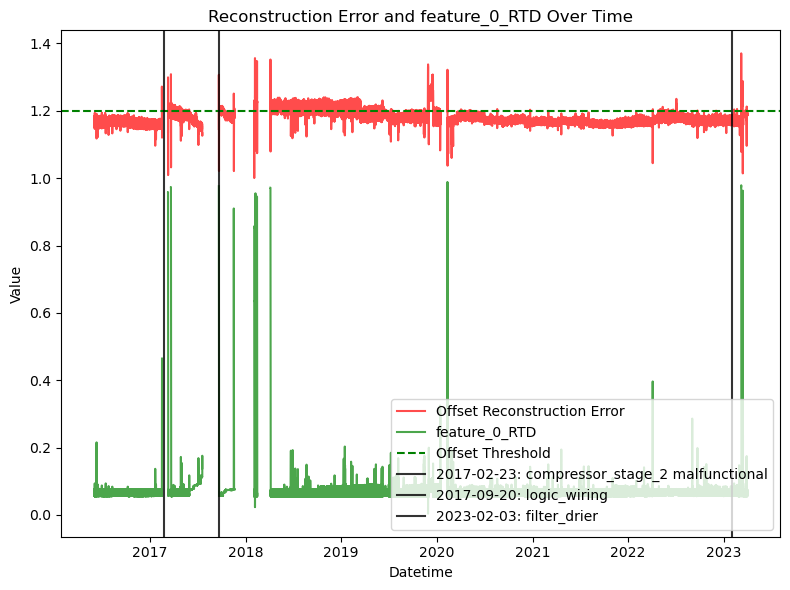

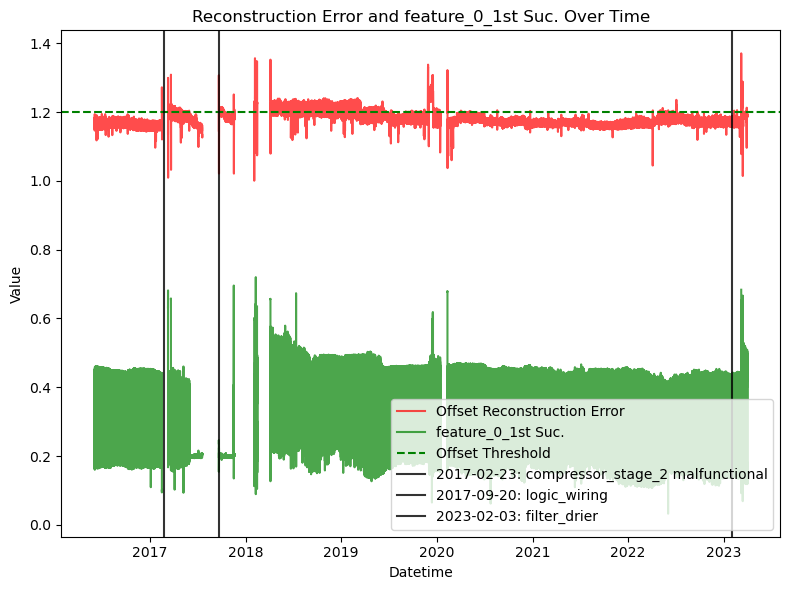

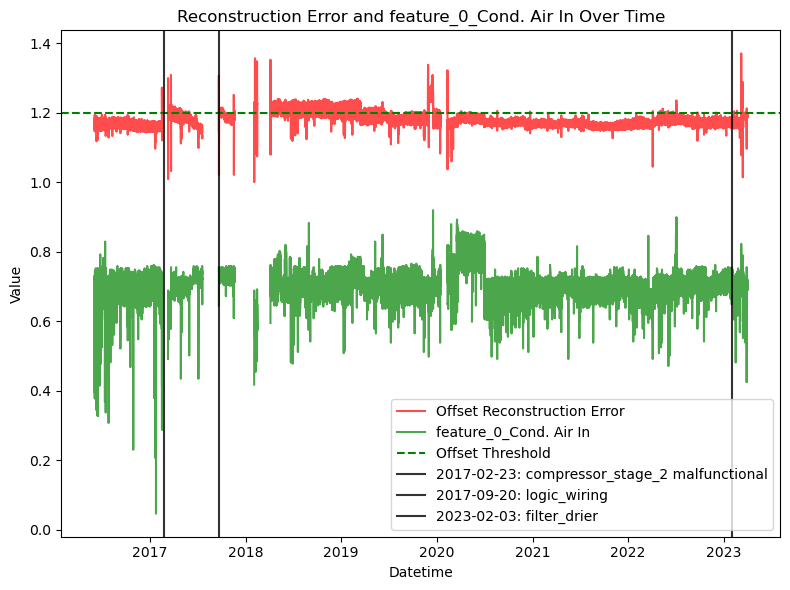

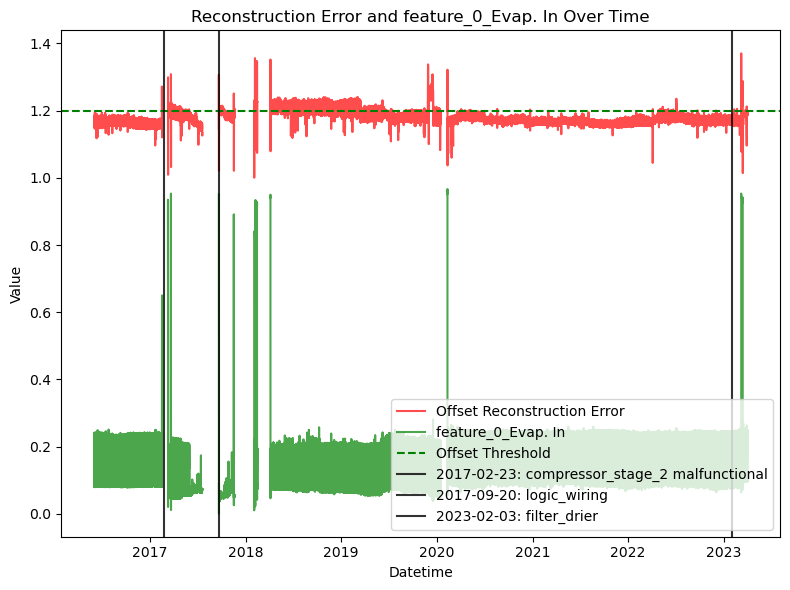

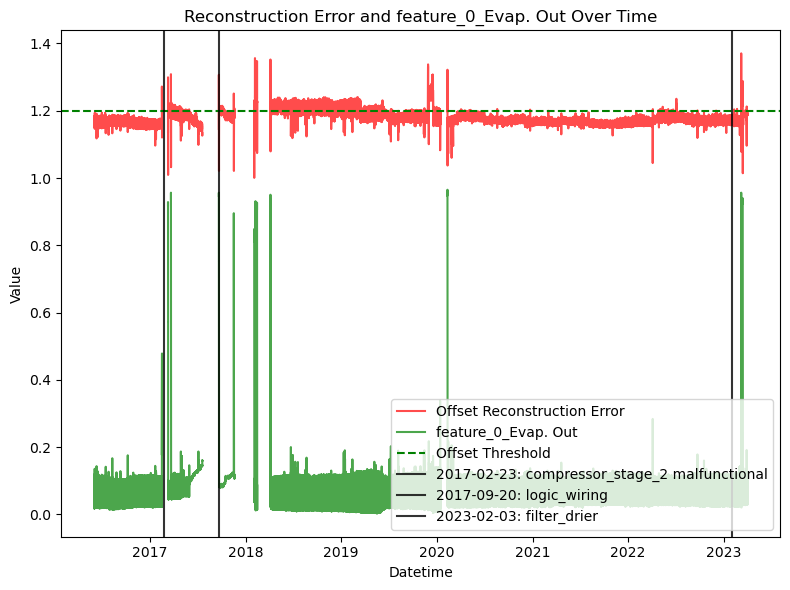

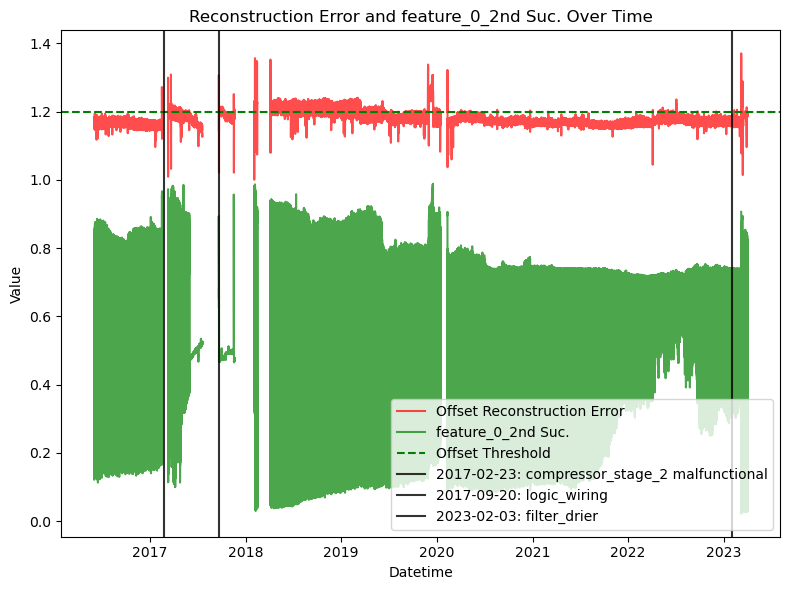

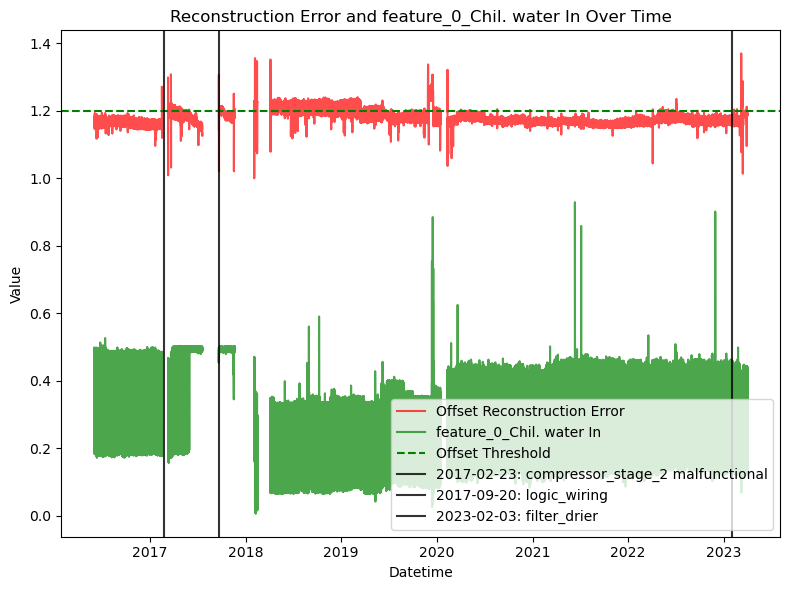

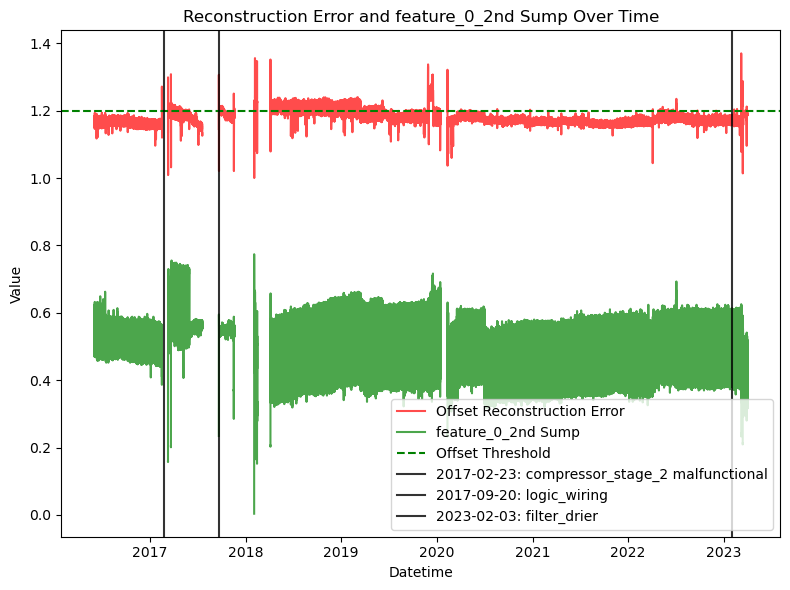

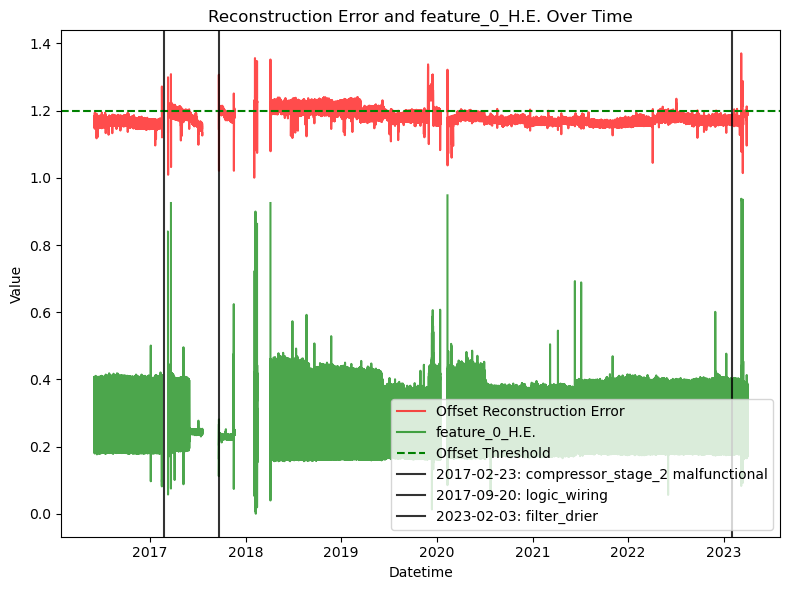

Detected 453,321 anomalies out of 3,211,690 samples.


In [11]:
# Define the date range for filtering
start_date = '2016-06-01'
end_date = '2023-12-31'

# Filter the DataFrame to include only rows within the specified range
filtered_results_df = results_df[(results_df['Datetime'] >= start_date) & (results_df['Datetime'] <= end_date)]

# Columns to plot
columns_to_plot = [
    'feature_0_RTD', 'feature_0_1st Suc.', 'feature_0_Cond. Air In',
    'feature_0_Evap. In', 'feature_0_Evap. Out', 'feature_0_2nd Suc.',
    'feature_0_Chil. water In', 'feature_0_2nd Sump', 'feature_0_H.E.'
]

# Event dates to mark on the plot
event_dates = ['2017-02-23', '2017-09-20', '2023-02-03']
event_types = ['compressor_stage_2 malfunctional', 'logic_wiring', 'filter_drier']
event_dates = pd.to_datetime(event_dates)  # Convert to datetime

# Offset reconstruction error and threshold by 0.8
results_df['offset_reconstruction_error'] = results_df['reconstruction_error'] * 5 + 0.8
offset_threshold = threshold * 5 + 0.8

# Calculate time differences between consecutive rows
time_diffs = results_df['Datetime'].diff()

# Define a threshold for detecting gaps (e.g., 1 month)
gap_threshold = pd.Timedelta(days=1)

# Introduce NaN for rows where the time difference exceeds the threshold
results_df.loc[time_diffs > gap_threshold, 'offset_reconstruction_error'] = np.nan
for column in columns_to_plot:
    if column in results_df.columns:
        results_df.loc[time_diffs > gap_threshold, column] = np.nan

# Generate a plot for each specified column
for column in columns_to_plot:
    plt.figure(figsize=(8, 6))
    
    # Plot offset reconstruction error
    plt.plot(filtered_results_df['Datetime'], filtered_results_df['offset_reconstruction_error'],
             label='Offset Reconstruction Error', color='red', alpha=0.7)
    
    # Plot the current column
    if column in filtered_results_df.columns:
        plt.plot(filtered_results_df['Datetime'], filtered_results_df[column],
                 label=column, color='green', alpha=0.7)
    else:
        print(f"Warning: Column '{column}' not found in filtered_results_df.")
        continue  # Skip to the next column if not found

    # Add a horizontal line for the offset threshold
    plt.axhline(y=offset_threshold, color='green', linestyle='--', label='Offset Threshold')
    
    # Add vertical black lines for each event date
    for event_date, event_type in zip(event_dates, event_types):
        plt.axvline(event_date, color='black', linestyle='-', alpha=0.8, label=f'{event_date.date()}: {event_type}')
        
    # Configure plot labels and title
    plt.xlabel('Datetime')
    plt.ylabel('Value')
    plt.title(f'Reconstruction Error and {column} Over Time')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

# Print anomaly statistics for the filtered data
anomaly_count = filtered_results_df['anomaly'].sum()
print(f"Detected {anomaly_count:,} anomalies out of {len(filtered_results_df):,} samples.")